In [528]:
%cd ../src

/Users/ivamilojkovic/Breast-Cancer-Analysis/src


In [529]:
import pandas as pd
import pickle, os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import normalize

plt.style.use('ggplot')
sns.set_theme()
plt.rcParams["figure.figsize"] = (12, 4)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

import warnings
warnings.filterwarnings('ignore')

# BRCA

In [530]:
# Load one sheet/table about DFS
df_clinical_dfs = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='ALL BREAST TCGA-PANCA DFS')
df_clinical_dfs.head()

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971


In [531]:
# Load one sheet/table about OS
df_clinical_os = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='ALL BREAST TCGA PANCA OS')
print(df_clinical_os.shape)
df_clinical_os.head()

(1084, 4)


,Study ID,Patient ID,OS_STATUS,OS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,LIVING,133.050597
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,LIVING,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,LIVING,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,LIVING,47.604958
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,LIVING,11.440971


In [532]:
# Get the name of the columns that need to be added
df_clinical_out_cols = pd.read_excel(r'../data/OS_DFS_TCGA_TCGATEST_PANCA.xlsx', engine='openpyxl', sheet_name='EXAMPLE output - OS DFS SUBTYPE').columns
df_clinical_out_cols = df_clinical_out_cols[:-2]
df_clinical_out_cols

Index(['Patient ID', 'DFS_STATUS', 'DFS_MONTHS', 'RECURRED BEFORE 5 YEARS',
       'RECURRED AFTER FIVE YEARS', 'DISEASE FREE FOR LESS THAN 5 YEARS',
       'DISEASE FREE FOR MORE THAN 5 YEARS', 'OS_STATUS', 'OS_MONTHS',
       'DECEASED WITHIN 5 YEARS', 'SUBTYPE', 'IS LUMA',
       'TRAINING OR TESTING?'],
      dtype='object')

In [533]:
# Load the multilabel dataset (contains genes, correlations)
with open('../data/dataset_multilabel.pkl', 'rb') as file:
    df_multi = pickle.load(file)

# Set negative correlations to zero
labels = ['LumA', 'LumB', 'Basal', 'Her2', 'Normal']
df_multi[labels] = discard_negative_correlations(df_multi[labels])

print(df_multi.shape)
df_multi.head()

(1053, 25159)


,tcga_id,expert_PAM50_subtype,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,ZYX,ZZEF1,ZZZ3,Subtype-from Parker centroids,MaxCorr,Basal,Her2,LumA,LumB,Normal
0,TCGA-3C-AAAU,LumA,57898,67829,134,1697402,44314,1737,568,0,...,1054121,557596,409660,LumA,0.373445,0.0,0.000000,0.373445,0.179928,0.000000
1,TCGA-3C-AALI,Her2,52146,65152,1361,1403901,36852,1636,1357,41,...,1041074,247545,88163,Her2,0.647827,0.0,0.647827,0.000000,0.247731,0.000000
2,TCGA-3C-AALJ,LumB,52172,29356,510,989281,30378,282,1974,119,...,613785,110466,68745,LumB,0.357503,0.0,0.000000,0.144970,0.357503,0.000000
3,TCGA-3C-AALK,LumA,50517,43436,287,2674831,69374,816,2084,172,...,1397623,196615,206477,LumA,0.666747,0.0,0.000000,0.666747,0.000000,0.458535
4,TCGA-4H-AAAK,LumA,66433,66229,192,2279532,56667,1603,2425,246,...,970767,199472,246179,LumA,0.556303,0.0,0.000000,0.556303,0.000000,0.503962


In [534]:
# Merge the dataframes based on the 'ID' column (keep in mind, some NaNs will appear)
merged_df = pd.merge(df_clinical_dfs, df_clinical_os, on=['Patient ID', 'Study ID'])
print('Unique values in OS_STATUS columns: ', merged_df['OS_STATUS'].unique())
merged_df

Unique values in OS_STATUS columns:  ['LIVING' 'DECEASED' nan]


,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444,LIVING,133.050597
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790,LIVING,131.669790
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743,LIVING,48.459743
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN,LIVING,47.604958
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971,LIVING,11.440971
...,...,...,...,...,...,...
1079,brca_tcga_pan_can_atlas_2018,TCGA-WT-AB44,DiseaseFree,29.029819,LIVING,29.029819
1080,brca_tcga_pan_can_atlas_2018,TCGA-XX-A899,DiseaseFree,15.353256,LIVING,15.353256
1081,brca_tcga_pan_can_atlas_2018,TCGA-XX-A89A,DiseaseFree,16.043660,LIVING,16.043660
1082,brca_tcga_pan_can_atlas_2018,TCGA-Z7-A8R5,NaN,NaN,LIVING,108.064569


In [535]:
# Add new columns linked to time (5 years in this case)
merged_df['DISEASE FREE FOR MORE THAN 5 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] > 5*12)
merged_df['DISEASE FREE FOR LESS THAN 5 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] <= 5*12)
merged_df['RECURRED AFTER 5 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] > 5*12)
merged_df['RECURRED BEFORE 5 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] <= 5*12)
merged_df['DECEASED WITHIN 5 YEARS'] = (merged_df['OS_STATUS'] == 'DECEASED') & (merged_df['OS_MONTHS'] <= 5*12)

merged_df['DISEASE FREE FOR MORE THAN 10 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] > 10*12)
merged_df['DISEASE FREE FOR LESS THAN 10 YEARS'] = (merged_df['DFS_STATUS'] == 'DiseaseFree') & (merged_df['DFS_MONTHS'] <= 10*12)
merged_df['RECURRED AFTER 10 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] > 10*12)
merged_df['RECURRED BEFORE 10 YEARS'] = (merged_df['DFS_STATUS'] == 'Recurred/Progressed') & (merged_df['DFS_MONTHS'] <= 10*12)
merged_df['DECEASED WITHIN 10 YEARS'] = (merged_df['OS_STATUS'] == 'DECEASED') & (merged_df['OS_MONTHS'] <= 10*12)
merged_df

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,DISEASE FREE FOR MORE THAN 10 YEARS,DISEASE FREE FOR LESS THAN 10 YEARS,RECURRED AFTER 10 YEARS,RECURRED BEFORE 10 YEARS,DECEASED WITHIN 10 YEARS
0,brca_tcga_pan_can_atlas_2018,TCGA-3C-AAAU,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False,False,False,False,True,False
1,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALI,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False,True,False,False,False,False
2,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALJ,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False,False,True,False,False,False
3,brca_tcga_pan_can_atlas_2018,TCGA-3C-AALK,NaN,NaN,LIVING,47.604958,False,False,False,False,False,False,False,False,False,False
4,brca_tcga_pan_can_atlas_2018,TCGA-4H-AAAK,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,brca_tcga_pan_can_atlas_2018,TCGA-WT-AB44,DiseaseFree,29.029819,LIVING,29.029819,False,True,False,False,False,False,True,False,False,False
1080,brca_tcga_pan_can_atlas_2018,TCGA-XX-A899,DiseaseFree,15.353256,LIVING,15.353256,False,True,False,False,False,False,True,False,False,False
1081,brca_tcga_pan_can_atlas_2018,TCGA-XX-A89A,DiseaseFree,16.043660,LIVING,16.043660,False,True,False,False,False,False,True,False,False,False
1082,brca_tcga_pan_can_atlas_2018,TCGA-Z7-A8R5,NaN,NaN,LIVING,108.064569,False,False,False,False,False,False,False,False,False,False


In [536]:
# Rename tcga_id columns
df_multi.rename(columns={'tcga_id': 'Patient ID'}, inplace=True)

# Connect the original multilabel dataset and previously formed DataFrame with DFS and OS information
df_multi_merged = pd.merge(df_multi, merged_df, on='Patient ID', how='left')
df_multi_merged

,Patient ID,expert_PAM50_subtype,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,...,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,DISEASE FREE FOR MORE THAN 10 YEARS,DISEASE FREE FOR LESS THAN 10 YEARS,RECURRED AFTER 10 YEARS,RECURRED BEFORE 10 YEARS,DECEASED WITHIN 10 YEARS
0,TCGA-3C-AAAU,LumA,57898,67829,134,1697402,44314,1737,568,0,...,False,False,False,True,False,False,False,False,True,False
1,TCGA-3C-AALI,Her2,52146,65152,1361,1403901,36852,1636,1357,41,...,True,False,False,False,False,True,False,False,False,False
2,TCGA-3C-AALJ,LumB,52172,29356,510,989281,30378,282,1974,119,...,False,True,False,False,False,False,True,False,False,False
3,TCGA-3C-AALK,LumA,50517,43436,287,2674831,69374,816,2084,172,...,False,False,False,False,False,False,False,False,False,False
4,TCGA-4H-AAAK,LumA,66433,66229,192,2279532,56667,1603,2425,246,...,False,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,141068,86135,192,9999765,628915,1283,16684,51,...,True,False,False,False,False,False,True,False,False,False
1049,TCGA-E2-A108,Normal,36667,39082,223,9380667,176967,4530,9219,165,...,False,True,False,False,False,False,True,False,False,False
1050,TCGA-EW-A1P7,Normal,32150,37899,71,6707683,139652,556063,12178,70,...,False,False,False,True,False,False,False,False,True,False
1051,TCGA-EW-A1PG,Normal,17379,29996,69,5658389,94026,1061,4606,23,...,False,True,False,False,False,False,True,False,False,False


In [537]:
df_multi_merged.drop(columns=df_multi_merged.columns[2:-22], inplace=True)
df_multi_merged.drop(columns=['MaxCorr','Basal','Her2','LumA','LumB', 'Normal', 'Study ID'], inplace=True)
df_multi_merged

,Patient ID,expert_PAM50_subtype,Subtype-from Parker centroids,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,DISEASE FREE FOR MORE THAN 10 YEARS,DISEASE FREE FOR LESS THAN 10 YEARS,RECURRED AFTER 10 YEARS,RECURRED BEFORE 10 YEARS,DECEASED WITHIN 10 YEARS
0,TCGA-3C-AAAU,LumA,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False,False,False,False,True,False
1,TCGA-3C-AALI,Her2,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False,True,False,False,False,False
2,TCGA-3C-AALJ,LumB,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False,False,True,False,False,False
3,TCGA-3C-AALK,LumA,LumA,NaN,NaN,LIVING,47.604958,False,False,False,False,False,False,False,False,False,False
4,TCGA-4H-AAAK,LumA,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False,False,True,False,False,False
1049,TCGA-E2-A108,Normal,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False,False,True,False,False,False
1050,TCGA-EW-A1P7,Normal,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False,False,False,False,True,False
1051,TCGA-EW-A1PG,Normal,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False,False,True,False,False,False


In [538]:
# There are 36 samples that were not found in the multi-label dataset
rest_patient_id = (set(merged_df['Patient ID'])) - set(df_multi['Patient ID']) 

# Find indices of rest patient IDs
indices = merged_df.loc[merged_df['Patient ID'].isin(rest_patient_id)].index

# Extract the part of the original clinical data
df_rest_clinical = merged_df.iloc[indices, :]
df_rest_clinical.head()

,Study ID,Patient ID,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,DISEASE FREE FOR MORE THAN 10 YEARS,DISEASE FREE FOR LESS THAN 10 YEARS,RECURRED AFTER 10 YEARS,RECURRED BEFORE 10 YEARS,DECEASED WITHIN 10 YEARS
44,brca_tcga_pan_can_atlas_2018,TCGA-A2-A0CZ,NaN,NaN,LIVING,53.128185,False,False,False,False,False,False,False,False,False,False
130,brca_tcga_pan_can_atlas_2018,TCGA-A7-A0DC,DiseaseFree,29.785975,LIVING,29.785975,False,True,False,False,False,False,True,False,False,False
152,brca_tcga_pan_can_atlas_2018,TCGA-A7-A4SC,DiseaseFree,14.662853,LIVING,14.662853,False,True,False,False,False,False,True,False,False,False
178,brca_tcga_pan_can_atlas_2018,TCGA-A8-A07C,DiseaseFree,33.994148,LIVING,33.994148,False,True,False,False,False,False,True,False,False,False
188,brca_tcga_pan_can_atlas_2018,TCGA-A8-A07S,NaN,NaN,LIVING,7.988954,False,False,False,False,False,False,False,False,False,False


In [539]:
# Mergre DISEASE FREE FOR MORE THAN 5 YEARS and RECURRED BEFORE 5 YEARS
df_multi_merged['Reccured within 5 years'] = [False if (val_1==True and val_2==False) else True for val_1, val_2 in zip(df_multi_merged['DISEASE FREE FOR MORE THAN 5 YEARS'].values,  df_multi_merged['RECURRED BEFORE 5 YEARS'].values)]
df_multi_merged

,Patient ID,expert_PAM50_subtype,Subtype-from Parker centroids,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,DISEASE FREE FOR MORE THAN 10 YEARS,DISEASE FREE FOR LESS THAN 10 YEARS,RECURRED AFTER 10 YEARS,RECURRED BEFORE 10 YEARS,DECEASED WITHIN 10 YEARS,Reccured within 5 years
0,TCGA-3C-AAAU,LumA,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False,False,False,False,True,False,True
1,TCGA-3C-AALI,Her2,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False,True,False,False,False,False,False
2,TCGA-3C-AALJ,LumB,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,False,False,False,True,False,False,False,True
3,TCGA-3C-AALK,LumA,LumA,NaN,NaN,LIVING,47.604958,False,False,False,False,False,False,False,False,False,False,True
4,TCGA-4H-AAAK,LumA,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False,False,True,False,False,False,False
1049,TCGA-E2-A108,Normal,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,False,False,False,True,False,False,False,True
1050,TCGA-EW-A1P7,Normal,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False,False,False,False,True,False,True
1051,TCGA-EW-A1PG,Normal,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,False,False,False,True,False,False,False,True


In [540]:
# Check how many rows have NaNs
df_multi_merged.isna().sum(axis=0)

Patient ID                               0
expert_PAM50_subtype                     0
Subtype-from Parker centroids            0
DFS_STATUS                             140
DFS_MONTHS                             141
OS_STATUS                                5
OS_MONTHS                                6
DISEASE FREE FOR MORE THAN 5 YEARS       5
DISEASE FREE FOR LESS THAN 5 YEARS       5
RECURRED AFTER 5 YEARS                   5
RECURRED BEFORE 5 YEARS                  5
DECEASED WITHIN 5 YEARS                  5
DISEASE FREE FOR MORE THAN 10 YEARS      5
DISEASE FREE FOR LESS THAN 10 YEARS      5
RECURRED AFTER 10 YEARS                  5
RECURRED BEFORE 10 YEARS                 5
DECEASED WITHIN 10 YEARS                 5
Reccured within 5 years                  0
dtype: int64

In [541]:
# Remove NaN rows and check if they are removed
df_multi_merged.dropna(inplace=True)
df_multi_merged.isna().sum()

Patient ID                             0
expert_PAM50_subtype                   0
Subtype-from Parker centroids          0
DFS_STATUS                             0
DFS_MONTHS                             0
OS_STATUS                              0
OS_MONTHS                              0
DISEASE FREE FOR MORE THAN 5 YEARS     0
DISEASE FREE FOR LESS THAN 5 YEARS     0
RECURRED AFTER 5 YEARS                 0
RECURRED BEFORE 5 YEARS                0
DECEASED WITHIN 5 YEARS                0
DISEASE FREE FOR MORE THAN 10 YEARS    0
DISEASE FREE FOR LESS THAN 10 YEARS    0
RECURRED AFTER 10 YEARS                0
RECURRED BEFORE 10 YEARS               0
DECEASED WITHIN 10 YEARS               0
Reccured within 5 years                0
dtype: int64

In [542]:
# Extract samples for disease reccured within 5 years
recc_within_5_years_bool = ((df_multi_merged['DISEASE FREE FOR MORE THAN 5 YEARS']==False) & (df_multi_merged['RECURRED BEFORE 5 YEARS']==False))==False
print('Kept number of samples for reccured within 5 years analysis: ', recc_within_5_years_bool.sum())

Kept number of samples for reccured within 5 years analysis:  248


In [543]:
df_multi_merged_recc_within_5_years = df_multi_merged.loc[recc_within_5_years_bool, :]
df_multi_merged_recc_within_5_years

,Patient ID,expert_PAM50_subtype,Subtype-from Parker centroids,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,RECURRED BEFORE 5 YEARS,DECEASED WITHIN 5 YEARS,DISEASE FREE FOR MORE THAN 10 YEARS,DISEASE FREE FOR LESS THAN 10 YEARS,RECURRED AFTER 10 YEARS,RECURRED BEFORE 10 YEARS,DECEASED WITHIN 10 YEARS,Reccured within 5 years
0,TCGA-3C-AAAU,LumA,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,True,False,False,False,False,True,False,True
1,TCGA-3C-AALI,Her2,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,False,False,True,False,False,False,False,False
12,TCGA-A2-A0YJ,Basal,Basal,Recurred/Progressed,18.377881,LIVING,18.608015,False,False,False,True,False,False,False,False,True,False,True
61,TCGA-AO-A03L,LumA,LumA,DiseaseFree,80.284052,LIVING,80.284052,True,False,False,False,False,False,True,False,False,False,False
62,TCGA-AO-A03M,LumA,LumA,DiseaseFree,61.347273,LIVING,61.347273,True,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1043,TCGA-AR-A2LH,Normal,Normal,Recurred/Progressed,14.268337,DECEASED,20.251833,False,False,False,True,True,False,False,False,True,True,True
1045,TCGA-B6-A0RQ,Normal,Normal,DiseaseFree,140.283394,DECEASED,140.283394,True,False,False,False,False,True,False,False,False,False,False
1048,TCGA-BH-A42U,Normal,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,False,False,False,True,False,False,False,False
1050,TCGA-EW-A1P7,Normal,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,True,False,False,False,False,True,False,True


# Creating DataFrames with Model Predictions

Since 6 models were selected each one of them gives prediction which will be used to create new datasets. These datasets will contain DFS, OS information, ground truth subtype from PAM50, information if a sample is predicted as LumA, taking into consideration the rank of the prediction (primary or secondary).

In [544]:
from data_preprocessing import remove_extreme

# Load test data (the split is the same as in the training workflow)
with open('../data/dataset_multilabel.pkl', 'rb') as file:
    data = pickle.load(file)
    X = data.drop(columns=['expert_PAM50_subtype', 'tcga_id',
                           'Subtype-from Parker centroids',	'MaxCorr',
                            'Basal', 'Her2', 'LumA', 'LumB', 'Normal'], inplace=False)
    y_orig = data.expert_PAM50_subtype
    y_pam50 = data['Subtype-from Parker centroids']

    # Remove extreme values (genes, samples) from initial preprocessing
    X, potential_samples_to_remove, \
        feat_to_remove, feat_to_keep = remove_extreme(X, change_X = True)

    # Take labels on whole dataset for PAM50
    y_corr = data[['Basal', 'Her2', 'LumA', 'LumB',	'Normal']]
    y_corr_non_neg = discard_negative_correlations(y_corr)

    # M-cut strategy to assign labels on whole dataset
    y_mcut_labels, _ = m_cut_strategy_class_assignment(y_corr, non_neg_values=True)
    y_mcut_labels_neg, _ = m_cut_strategy_class_assignment(y_corr, non_neg_values=False)
    
    # Compute labels from two strategies (M-cut and 5th percentile)
    y_mcut_5perc_labels, _ = create_mcut_nth_percentile_labels(
        m_cut_labels=y_mcut_labels,
        correlations=y_corr_non_neg,
        y=y_pam50,
        keep_primary= False,
        N=5
    )
    
    X_train, X_test, \
    y_train_pam50, y_test_pam50, \
    y_train_mcut, y_test_mcut, \
    y_train_orig, y_test_orig, \
    y_train_5perc, y_test_5perc, \
    y_train_corr, y_test_corr = \
        train_test_split(X, y_pam50, y_mcut_labels, y_orig, 
                        y_mcut_5perc_labels, y_corr_non_neg, test_size=0.3, random_state=1, stratify=y_pam50)

    # Data standardization | normalization
    X_train = X_train.divide(X_train.sum(axis=1), axis=0) * 1e6
    X_test = X_test.divide(X_test.sum(axis=1), axis=0) * 1e6
    scaler = FunctionTransformer(log_transform)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    # # Load selected features
    # with open('../data/brca/without_corr_removed_feat_select_gt_50_perc_occur.pkl', 'rb') as file:
    #     selected_feat = pickle.load(file)

    selected_feat = pd.read_csv('../data/rare_feat_750_BRCA.csv', index_col=0).values
    selected_feat = [elem[0] for elem in selected_feat]

    X_train_scaled_selected = X_train_scaled[list(selected_feat)]
    X_test_scaled_selected = X_test_scaled[list(selected_feat)]

    # One-hot encoding of original and PAM50 labels
    y_train_orig = pd.get_dummies(y_train_orig)
    y_test_orig = pd.get_dummies(y_test_orig)
    y_train_pam50 = pd.get_dummies(y_train_pam50)
    y_test_pam50_orig = y_test_pam50
    y_test_pam50 = pd.get_dummies(y_test_pam50)

    # Merged train and test
    X_scaled_selected = pd.concat([X_train_scaled_selected, X_test_scaled_selected], axis=0)
    X_scaled_selected = X_scaled_selected.sort_index()


There are 0 columns with more than 80% of Null values!
There are 22722 columns with more than 20% of count values greater than 4!


Text(0, 0.5, '')

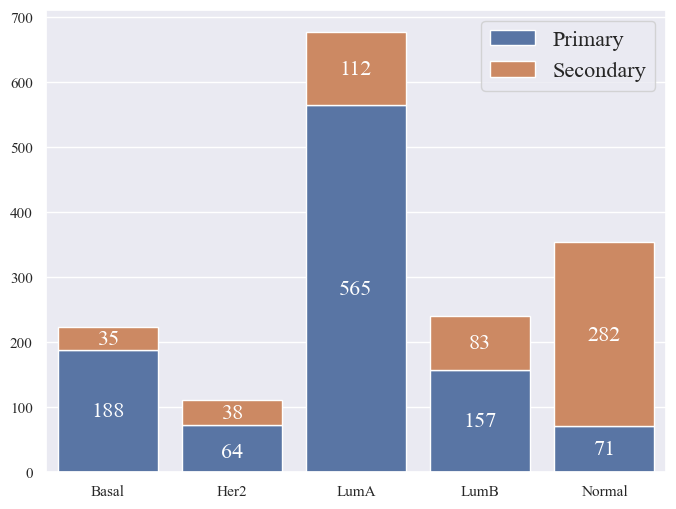

In [545]:
# Class distribution (counts) comparison
ax = plt.figure(figsize=(8,6))

df_compare = pd.DataFrame({
    'Primary': data['Subtype-from Parker centroids'].value_counts(),
    'Secondary': y_mcut_5perc_labels.sum(axis=0) - data['Subtype-from Parker centroids'].value_counts()
    }, 
    index=y_mcut_labels.columns)

df_compare['Secondary']['Basal'] += 20
df_compare['Secondary']['Her2'] += 8

palette = sns.color_palette()

# Plot the stacked bar chart using the custom palette
ax = sns.barplot(data=df_compare, x=df_compare.index, y='Primary', label='Primary',color=palette[0])
ax = sns.barplot(data=df_compare, x=df_compare.index, y='Secondary', label='Secondary', bottom=df_compare['Primary'], color=palette[1])

# Add values inside the bars
for i, p in enumerate(ax.patches):
    if i==0:
        height = p.get_height() - 20
    if i==1:
        height = p.get_height() - 8
    else:
        height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy() 
    ax.annotate(f'{int(height)}', (x + width / 2, y + height / 2 - 2), ha='center', va='center', fontsize=16, color='white')


# Show the legend
ax.legend(fontsize=16)
ax.set_ylabel('')


In [546]:
# Get test indices (here we are using only labels obtained with M-cut strategy and 5th percentile filtering)
test_idx = y_test_5perc.index
test_tcga_idx = df_multi.iloc[test_idx, 0]
test_tcga_idx

34     TCGA-AC-A6IW
786    TCGA-C8-A27A
451    TCGA-AC-A2QI
11     TCGA-A2-A0YE
599    TCGA-D8-A27I
           ...     
995    TCGA-A2-A25B
917    TCGA-C8-A26X
148    TCGA-C8-A8HR
946    TCGA-AN-A0FN
991    TCGA-A1-A0SN
Name: Patient ID, Length: 316, dtype: object

### Load signle-label and multi-label models

In [547]:
path_brca_sl = '../final_results/BRCA/single-label/SUBTYPE_PAM50/feat_select_RERA/feat_750'

# Loading the best models for each approach in single-label
# with open(os.path.join(path_brca_sl, 'bestmodel_XGBoost_run_17-09-2023_22:24:46.pkl'), 'rb') as f:
#     brca_model_xgb = pickle.load(f)
# with open(os.path.join(path_brca_sl, 'bestmodel_LogisticRegression_run_17-09-2023_23:43:59.pkl'), 'rb') as f:
#     brca_model_lr = pickle.load(f)
# with open(os.path.join(path_brca_sl, 'bestmodel_RandomForest_run_17-09-2023_22:06:55.pkl'), 'rb') as f:
#     brca_model_rf = pickle.load(f)
# with open(os.path.join(path_brca_sl, 'bestmodel_SVC_run_17-09-2023_21:17:33.pkl'), 'rb') as f:
#     brca_model_svm = pickle.load(f)

# with open(os.path.join(path_brca_sl, 'bestmodel_XGBoost_run_26-10-2023_23:48:25.pickle'), 'rb') as f:
#     brca_model_xgb = pickle.load(f)
# with open(os.path.join(path_brca_sl, 'bestmodel_LogisticRegression_run_26-10-2023_21:51:16.pickle'), 'rb') as f:
#     brca_model_lr = pickle.load(f)
# with open(os.path.join(path_brca_sl, 'bestmodel_RandomForest_run_26-10-2023_22:39:03.pickle'), 'rb') as f:
#     brca_model_rf = pickle.load(f)
# with open(os.path.join(path_brca_sl, 'bestmodel_SVC_run_26-10-2023_22:58:55.pickle'), 'rb') as f:
#     brca_model_svm = pickle.load(f)

with open(os.path.join(path_brca_sl, 'best_model_XGBoost.pkl'), 'rb') as f:
    brca_model_xgb = pickle.load(f)
with open(os.path.join(path_brca_sl, 'best_model_LogisticRegression.pkl'), 'rb') as f:
    brca_model_lr = pickle.load(f)
with open(os.path.join(path_brca_sl, 'best_model_RandomForest.pkl'), 'rb') as f:
    brca_model_rf = pickle.load(f)
with open(os.path.join(path_brca_sl, 'best_model_SVC.pkl'), 'rb') as f:
    brca_model_svm = pickle.load(f)

path_brca_ml = '../final_results/BRCA/multi-label/feat_select_RERA/'
path_brca_ml_pt = os.path.join(path_brca_ml, '22-09-2023_14:56:42')
# path_brca_ml_pt = os.path.join(path_brca_ml, '20-10-2023_16:02:07')

# Logistic Regression - Binary Relevance
with open(os.path.join(path_brca_ml_pt, 'BR_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_lr_br = pickle.load(file)
# Logistic Regression - Classifier Chain 
with open(os.path.join(path_brca_ml_pt, 'CC_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_lr_cc = pickle.load(file)
# Logistic Regression - Label Powerset
with open(os.path.join(path_brca_ml_pt, 'LP_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_lr_lp = pickle.load(file)

# XGBoost - Binary Relevance
with open(os.path.join(path_brca_ml_pt, 'BR_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_xgb_br = pickle.load(file)
# XGBoost - Classifier Chain 
with open(os.path.join(path_brca_ml_pt, 'CC_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_xgb_cc = pickle.load(file)
# XGBoost - Label Powerset 
with open(os.path.join(path_brca_ml_pt, 'LP_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_xgb_lp = pickle.load(file)

# SVM - Label Powerset 
with open(os.path.join(path_brca_ml_pt, 'LP_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_svm_lp = pickle.load(file)

# Ensemble
with open(os.path.join(path_brca_ml_pt, 'EnsembleRakel_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_er_xgb = pickle.load(file)
with open(os.path.join(path_brca_ml_pt, 'EnsembleCC_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_ecc_xgb = pickle.load(file)
with open(os.path.join(path_brca_ml_pt, 'EnsembleCC_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_ecc_lr = pickle.load(file)
with open(os.path.join(path_brca_ml_pt, 'EnsembleRakel_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
    brca_ml_model_er_lr = pickle.load(file)

In [548]:
# path_brca_sl = '../final_results/BRCA/single-label/SUBTYPE_PAM50/feat_select_hybrid'

# # Loading the best models for each approach in single-label
# with open(os.path.join(path_brca_sl, 'bestmodel_XGBoost_run_28-08-2023_05:09:55.pkl'), 'rb') as f:
#     brca_model_xgb = pickle.load(f)

# with open(os.path.join(path_brca_sl, 'bestmodel_LogisticRegression_run_28-08-2023_13:08:54.pkl'), 'rb') as f:
#     brca_model_lr = pickle.load(f)

# with open(os.path.join(path_brca_sl, 'bestmodel_RandomForest_run_28-08-2023_13:44:47.pkl'), 'rb') as f:
#     brca_model_rf = pickle.load(f)

# with open(os.path.join(path_brca_sl, 'bestmodel_SVC_run_28-08-2023_14:00:35.pkl'), 'rb') as f:
#     brca_model_svm = pickle.load(f)

# path_brca_ml = '../final_results/BRCA/multi-label'
# # path_brca_ml_pt = os.path.join(path_brca_ml, 'problem_transformation')
# path_brca_ml_pt = os.path.join(path_brca_ml, '03-09-2023_18:41:10')

# # Logistic Regression - Binary Relevance
# with open(os.path.join(path_brca_ml_pt, 'BR_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_lr_br = pickle.load(file)

# # Logistic Regression - Classifier Chain 
# with open(os.path.join(path_brca_ml_pt, 'CC_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_lr_cc = pickle.load(file)

# # Logistic Regression - Label Powerset
# with open(os.path.join(path_brca_ml_pt, 'LP_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_lr_lp = pickle.load(file)

# # XGBoost - Binary Relevance
# with open(os.path.join(path_brca_ml_pt, 'BR_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_xgb_br = pickle.load(file)

# # XGBoost - Classifier Chain 
# with open(os.path.join(path_brca_ml_pt, 'CC_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_xgb_cc = pickle.load(file)

# with open(os.path.join(path_brca_ml_pt, 'LP_RForest_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_rf_lp = pickle.load(file)

# with open(os.path.join(path_brca_ml_pt, 'LP_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_svm_lp = pickle.load(file)

# # path_ens_adapt = '../final_results/BRCA/multi-label/30-08-2023_03:55:43'
# path_brca_ml_ens = os.path.join(path_brca_ml, '04-09-2023_00:02:31')

# # Ensemble
# with open(os.path.join(path_brca_ml_ens, 'EnsembleRakel_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_er_xgb = pickle.load(file)

# with open(os.path.join(path_brca_ml_ens, 'EnsembleCC_XGBoost_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_ecc_xgb = pickle.load(file)

# with open(os.path.join(path_brca_ml_ens, 'EnsembleRakel_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_er_lr = pickle.load(file)

# with open(os.path.join(path_brca_ml_ens, 'EnsembleCC_LRegression_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_ecc_lr = pickle.load(file)

# with open(os.path.join(path_brca_ml_ens, 'EnsembleCC_SVC_mcut_5perc_bestmodel.pkl'), 'rb') as file:
#     brca_ml_model_ecc_svm = pickle.load(file)


In [549]:
brca_ml_model_lr_br.get_params()

{'classifier': LogisticRegression(C=1, random_state=4, solver='sag', tol=0.01),
 'classifier__C': 1,
 'classifier__class_weight': None,
 'classifier__dual': False,
 'classifier__fit_intercept': True,
 'classifier__intercept_scaling': 1,
 'classifier__l1_ratio': None,
 'classifier__max_iter': 100,
 'classifier__multi_class': 'auto',
 'classifier__n_jobs': None,
 'classifier__penalty': 'l2',
 'classifier__random_state': 4,
 'classifier__solver': 'sag',
 'classifier__tol': 0.01,
 'classifier__verbose': 0,
 'classifier__warm_start': False,
 'require_dense': [True, True]}

In [550]:
# # Loading the best models for each approach in multi-label

# with open('../models/multi-label_models/ml_best_model_lr03-07-2023_00:31:05.pkl', 'rb') as f:
#     model_xgb_br = pickle.load(f)

# with open('../models/multi-label_models/ml_chain_best_model_lr03-07-2023_02:03:48.pkl', 'rb') as f:
#     model_xgb_cc = pickle.load(f)

# with open('../models/multi-label_models/ml_best_model_lr05-07-2023_00:43:55.pkl', 'rb') as f:
#     model_lr_br = pickle.load(f)

# with open('../models/multi-label_models/ml_chain_best_model_lr05-07-2023_00:58:18.pkl', 'rb') as f:
#     model_lr_cc = pickle.load(f)

# with open('../models/multi-label_models/ml_best_model_lr06-07-2023_10:17:57.pkl', 'rb') as f:
#     model_svm_lp = pickle.load(f)

# with open('../models/multi-label_models/ml_best_model_lr05-07-2023_00:27:34.pkl', 'rb') as f:
#     model_rf_lp = pickle.load(f)


# # # Loading the best models for each approach in single-label
# # with open('../models/multi-label_models/bestmodel_run_08-05-2023_10:32:03.pkl', 'rb') as f:
# #     model_xgb = pickle.load(f)
# with open('../models/single-label_models/bestmodel_XGBoost_run_27-08-2023_04:59:35.pkl', 'rb') as f:
#     model_xgb = pickle.load(f)

# # with open('../models/multi-label_models/bestmodel_run_21-06-2023_20:22:21.pkl', 'rb') as f:
# #     model_lr = pickle.load(f)
# with open('../models/single-label_models/bestmodel_LogisticRegression_run_27-08-2023_03:04:29.pkl', 'rb') as f:
#     model_lr = pickle.load(f)

# # with open('../models/multi-label_models/bestmodel_run_21-06-2023_19:09:12.pkl', 'rb') as f:
# #     model_rf = pickle.load(f)
# with open('../models/single-label_models/bestmodel_RandomForest_run_27-08-2023_03:50:53.pkl', 'rb') as f:
#     model_rf = pickle.load(f)

# # with open('../models/multi-label_models/bestmodel_run_21-06-2023_21:42:11.pkl', 'rb') as f:
# #     model_svm = pickle.load(f)
# with open('../models/single-label_models/bestmodel_SVC_run_27-08-2023_04:14:38.pkl', 'rb') as f:
#     model_svm = pickle.load(f)


In [551]:
X_test_scaled_selected.shape, X_scaled_selected.shape

((316, 711), (1053, 711))

In [552]:
# from sklearn.metrics import accuracy_score
# # Define a mapping dictionary
# mapping = {0: 'Basal',1: 'Her2', 2: 'LumA', 3: 'LumB', 4: 'Normal'}

# ## Get the predictions and probabilities for each model and set the original test indices
# dataset_type = 'whole' # ['whole', 'test']
# if dataset_type == 'whole':
#     X_test_scaled_selected = X_scaled_selected
#     y_test_5perc = y_mcut_5perc_labels

# ############################### XGBoost ###############################
# # ------- Multi-label -------
# xgb_br_preds = brca_ml_model_xgb_br.predict(X_test_scaled_selected).toarray()
# xgb_br_preds = pd.DataFrame(xgb_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# xgb_br_prob_preds = brca_ml_model_xgb_br.predict_proba(X_test_scaled_selected).toarray()
# xgb_br_prob_preds = pd.DataFrame(xgb_br_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# xgb_cc_preds = brca_ml_model_xgb_cc.predict(X_test_scaled_selected).toarray()
# xgb_cc_preds = pd.DataFrame(xgb_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# xgb_cc_prob_preds = brca_ml_model_xgb_cc.predict_proba(X_test_scaled_selected).toarray()
# xgb_cc_prob_preds = pd.DataFrame(xgb_cc_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# # ------- Single-label -------
# xgb_preds = brca_model_xgb.predict(X_test_scaled_selected)
# xgb_preds = pd.Series(xgb_preds, index=y_test_5perc.index).map(mapping)

# # ############################### Logistic Regression ###############################
# # # ------- Multi-label -------
# lr_br_preds = brca_ml_model_lr_br.predict(X_test_scaled_selected).toarray()
# lr_br_preds = pd.DataFrame(lr_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# lr_br_prob_preds = brca_ml_model_lr_br.predict_proba(X_test_scaled_selected).toarray()
# lr_br_prob_preds = pd.DataFrame(lr_br_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# lr_cc_preds = brca_ml_model_lr_cc.predict(X_test_scaled_selected).toarray()
# lr_cc_preds = pd.DataFrame(lr_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# lr_cc_prob_preds = brca_ml_model_lr_cc.predict_proba(X_test_scaled_selected).toarray()
# lr_cc_prob_preds = pd.DataFrame(lr_cc_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# lr_lp_preds = brca_ml_model_lr_lp.predict(X_test_scaled_selected).toarray()
# lr_lp_preds = pd.DataFrame(lr_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# lr_lp_prob_preds = brca_ml_model_lr_lp.predict_proba(X_test_scaled_selected).toarray()
# lr_lp_prob_preds = pd.DataFrame(lr_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# # ------- Single-label -------
# lr_preds = brca_model_lr.predict(X_test_scaled_selected)
# lr_preds = pd.Series(lr_preds, index=y_test_5perc.index).map(mapping)

# # ############################### SVM ###############################
# # # ------- Multi-label -------
# svm_lp_preds = brca_ml_model_svm_lp.predict(X_test_scaled_selected).toarray()
# svm_lp_preds = pd.DataFrame(svm_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# svm_lp_prob_preds = brca_ml_model_svm_lp.predict_proba(X_test_scaled_selected).toarray()
# svm_lp_prob_preds = pd.DataFrame(svm_lp_prob_preds, index=y_test_5perc.index)
# # ------- Single-label -------
# svm_preds = brca_model_svm.predict(X_test_scaled_selected)
# svm_preds = pd.Series(svm_preds, index=y_test_5perc.index).map(mapping)

# # ############################### Random Forest ###############################
# # # ------- Multi-label -------
# rf_lp_preds = brca_ml_model_rf_lp.predict(X_test_scaled_selected).toarray()
# rf_lp_preds = pd.DataFrame(rf_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# rf_lp_prob_preds = brca_ml_model_rf_lp.predict_proba(X_test_scaled_selected).toarray()
# rf_lp_prob_preds = pd.DataFrame(rf_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# # ------- Single-label -------
# rf_preds = brca_model_rf.predict(X_test_scaled_selected)
# rf_preds = pd.Series(rf_preds, index=y_test_5perc.index).map(mapping)

# ######################## Ensemble ######################
# er_xgb_preds = brca_ml_model_er_xgb.predict(X_test_scaled_selected).toarray()
# er_xgb_preds = pd.DataFrame(er_xgb_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# er_xgb_prob_preds = brca_ml_model_er_xgb.predict_proba(X_test_scaled_selected).toarray()
# er_xgb_prob_preds = pd.DataFrame(er_xgb_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# ecc_xgb_preds = brca_ml_model_ecc_xgb.predict(X_test_scaled_selected)
# ecc_xgb_preds = pd.DataFrame(ecc_xgb_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# ecc_xgb_prob_preds = brca_ml_model_ecc_xgb.predict_proba(X_test_scaled_selected)
# ecc_xgb_prob_preds = normalize(np.array([ecc_xgb_prob_preds[i][:, 1] for i in range(5)]).transpose(), axis=1, norm='l1')
# ecc_xgb_prob_preds = pd.DataFrame(ecc_xgb_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# er_lr_preds = brca_ml_model_er_lr.predict(X_test_scaled_selected).todense()
# er_lr_preds = pd.DataFrame(er_lr_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# er_lr_prob_preds = brca_ml_model_er_lr.predict_proba(X_test_scaled_selected).todense()
# er_lr_prob_preds = pd.DataFrame(er_lr_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# ecc_lr_preds = brca_ml_model_ecc_lr.predict(X_test_scaled_selected)
# ecc_lr_preds = pd.DataFrame(ecc_lr_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# ecc_lr_prob_preds = brca_ml_model_ecc_lr.predict_proba(X_test_scaled_selected)
# ecc_lr_prob_preds = normalize(np.array([ecc_lr_prob_preds[i][:, 1] for i in range(5)]).transpose(), axis=1, norm='l1')
# ecc_lr_prob_preds = pd.DataFrame(ecc_lr_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# ecc_svm_preds = brca_ml_model_ecc_svm.predict(X_test_scaled_selected)
# ecc_svm_preds = pd.DataFrame(ecc_svm_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# ecc_svm_prob_preds = brca_ml_model_ecc_svm.predict_proba(X_test_scaled_selected)
# ecc_svm_prob_preds = normalize(np.array([ecc_svm_prob_preds[i][:, 1] for i in range(5)]).transpose(), axis=1, norm='l1')
# ecc_svm_prob_preds = pd.DataFrame(ecc_svm_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

In [553]:
from sklearn.metrics import accuracy_score
# Define a mapping dictionary
mapping = {0: 'Basal',1: 'Her2', 2: 'LumA', 3: 'LumB', 4: 'Normal'}

## Get the predictions and probabilities for each model and set the original test indices
dataset_type = 'whole' # ['whole', 'test']
if dataset_type == 'whole':
    X_test_scaled_selected = X_scaled_selected
    y_test_5perc = y_mcut_5perc_labels

############################### XGBoost ###############################
# ------- Multi-label -------
xgb_br_preds = brca_ml_model_xgb_br.predict(X_test_scaled_selected).toarray()
xgb_br_preds = pd.DataFrame(xgb_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
xgb_br_prob_preds = brca_ml_model_xgb_br.predict_proba(X_test_scaled_selected).toarray()
xgb_br_prob_preds = pd.DataFrame(xgb_br_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

xgb_cc_preds = brca_ml_model_xgb_cc.predict(X_test_scaled_selected).toarray()
xgb_cc_preds = pd.DataFrame(xgb_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
xgb_cc_prob_preds = brca_ml_model_xgb_cc.predict_proba(X_test_scaled_selected).toarray()
xgb_cc_prob_preds = pd.DataFrame(xgb_cc_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

xgb_lp_preds = brca_ml_model_xgb_lp.predict(X_test_scaled_selected).toarray()
xgb_lp_preds = pd.DataFrame(xgb_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
xgb_lp_prob_preds = brca_ml_model_xgb_lp.predict_proba(X_test_scaled_selected).toarray()
xgb_lp_prob_preds = pd.DataFrame(xgb_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
# ------- Single-label -------
xgb_preds = brca_model_xgb.predict(X_test_scaled_selected)
xgb_preds = pd.Series(xgb_preds, index=y_test_5perc.index).map(mapping)

# ############################### Logistic Regression ###############################
# # ------- Multi-label -------
lr_br_preds = brca_ml_model_lr_br.predict(X_test_scaled_selected).toarray()
lr_br_preds = pd.DataFrame(lr_br_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
lr_br_prob_preds = brca_ml_model_lr_br.predict_proba(X_test_scaled_selected).toarray()
lr_br_prob_preds = pd.DataFrame(lr_br_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_cc_preds = brca_ml_model_lr_cc.predict(X_test_scaled_selected).toarray()
lr_cc_preds = pd.DataFrame(lr_cc_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
lr_cc_prob_preds = brca_ml_model_lr_cc.predict_proba(X_test_scaled_selected).toarray()
lr_cc_prob_preds = pd.DataFrame(lr_cc_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

lr_lp_preds = brca_ml_model_lr_lp.predict(X_test_scaled_selected).toarray()
lr_lp_preds = pd.DataFrame(lr_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
lr_lp_prob_preds = brca_ml_model_lr_lp.predict_proba(X_test_scaled_selected).toarray()
lr_lp_prob_preds = pd.DataFrame(lr_lp_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

# ------- Single-label -------
lr_preds = brca_model_lr.predict(X_test_scaled_selected)
lr_preds = pd.Series(lr_preds, index=y_test_5perc.index).map(mapping)

rf_preds = brca_model_rf.predict(X_test_scaled_selected)
rf_preds = pd.Series(rf_preds, index=y_test_5perc.index).map(mapping)

# ############################### SVM ###############################
# # ------- Multi-label -------
svm_lp_preds = brca_ml_model_svm_lp.predict(X_test_scaled_selected).toarray()
svm_lp_preds = pd.DataFrame(svm_lp_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
svm_lp_prob_preds = brca_ml_model_svm_lp.predict_proba(X_test_scaled_selected).toarray()
svm_lp_prob_preds = pd.DataFrame(svm_lp_prob_preds, index=y_test_5perc.index)
# ------- Single-label -------
svm_preds = brca_model_svm.predict(X_test_scaled_selected)
svm_preds = pd.Series(svm_preds, index=y_test_5perc.index).map(mapping)

######################## Ensemble ######################
er_xgb_preds = brca_ml_model_er_xgb.predict(X_test_scaled_selected).toarray()
er_xgb_preds = pd.DataFrame(er_xgb_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
er_xgb_prob_preds = brca_ml_model_er_xgb.predict_proba(X_test_scaled_selected).toarray()
er_xgb_prob_preds = pd.DataFrame(er_xgb_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

ecc_xgb_preds = brca_ml_model_ecc_xgb.predict(X_test_scaled_selected)
ecc_xgb_preds = pd.DataFrame(ecc_xgb_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
ecc_xgb_prob_preds = brca_ml_model_ecc_xgb.predict_proba(X_test_scaled_selected)
ecc_xgb_prob_preds = normalize(np.array([ecc_xgb_prob_preds[i][:, 1] for i in range(5)]).transpose(), axis=1, norm='l1')
ecc_xgb_prob_preds = pd.DataFrame(ecc_xgb_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

ecc_lr_preds = brca_ml_model_ecc_lr.predict(X_test_scaled_selected)
ecc_lr_preds = pd.DataFrame(ecc_lr_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
ecc_lr_prob_preds = brca_ml_model_ecc_lr.predict_proba(X_test_scaled_selected)
ecc_lr_prob_preds = normalize(np.array([ecc_lr_prob_preds[i][:, 1] for i in range(5)]).transpose(), axis=1, norm='l1')
ecc_lr_prob_preds = pd.DataFrame(ecc_lr_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

er_lr_preds = brca_ml_model_er_lr.predict(X_test_scaled_selected).toarray()
er_lr_preds = pd.DataFrame(er_lr_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)
er_lr_prob_preds = brca_ml_model_er_lr.predict_proba(X_test_scaled_selected).toarray()
er_lr_prob_preds = pd.DataFrame(er_lr_prob_preds, columns=y_test_5perc.columns, index=y_test_5perc.index)

In [554]:
ecc_xgb_preds

,Basal,Her2,LumA,LumB,Normal
0,0,0,1,0,0
1,0,1,0,1,0
2,0,0,0,1,0
3,0,0,1,0,1
4,0,0,1,0,1
...,...,...,...,...,...
1048,0,0,1,0,1
1049,0,0,0,0,1
1050,1,0,0,0,1
1051,0,0,1,0,1


In [555]:
from multilabel_metrics import semi_relaxed_accuracy, ordered_subset_accuracy
# ordered_subset_accuracy(y_test_5perc, er_xgb_preds, y_test_corr, er_xgb_prob_preds)
# semi_relaxed_accuracy(xgb_cc_prob_preds, y_test_5perc)

In [556]:
def save_prediction(preds: pd.DataFrame, probs: pd.DataFrame) -> pd.DataFrame:

    # Take into account the rank of prediction i.e. labels
    ranked_indices = probs.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    ranked_corr_df = pd.DataFrame(ranked_indices.values.tolist(), columns=preds.columns, index=probs.index)
    rank_preds = preds * ranked_corr_df
    return rank_preds

save_prediction(xgb_br_preds, xgb_br_prob_preds).to_csv('../data/brca/predictions/xgb_br_pred.csv', index=False)
save_prediction(xgb_cc_preds, xgb_cc_prob_preds).to_csv('../data/brca/predictions/xgb_cc_pred.csv', index=False)
save_prediction(xgb_lp_preds, xgb_lp_prob_preds).to_csv('../data/brca/predictions/xgb_lp_pred.csv', index=False)
save_prediction(ecc_xgb_preds, ecc_xgb_prob_preds).to_csv('../data/brca/predictions/xgb_ecc_pred.csv', index=False)
save_prediction(er_xgb_preds, er_xgb_prob_preds).to_csv('../data/brca/predictions/xgb_er_pred.csv', index=False)

save_prediction(lr_br_preds, lr_br_prob_preds).to_csv('../data/brca/predictions/lr_br_pred.csv', index=False)
save_prediction(lr_cc_preds, lr_cc_prob_preds).to_csv('../data/brca/predictions/lr_cc_pred.csv', index=False)
save_prediction(lr_lp_preds, lr_lp_prob_preds).to_csv('../data/brca/predictions/lr_lp_pred.csv', index=False)
save_prediction(ecc_lr_preds, ecc_lr_prob_preds).to_csv('../data/brca/predictions/lr_ecc_pred.csv', index=False)
save_prediction(er_lr_preds, er_lr_prob_preds).to_csv('../data/brca/predictions/lr_er_pred.csv', index=False)

save_prediction(svm_lp_preds, svm_lp_prob_preds).to_csv('../data/brca/predictions/svm_lp_pred.csv', index=False)


In [557]:
xgb_preds

0         LumA
1         LumB
2         LumB
3         LumA
4         LumA
         ...  
1048    Normal
1049    Normal
1050    Normal
1051    Normal
1052    Normal
Length: 1053, dtype: object

In [558]:
y_test_pam50_orig, xgb_preds

(34      Basal
 786      LumB
 451      LumA
 11      Basal
 599      LumA
         ...  
 995      LumB
 917      Her2
 148    Normal
 946      LumA
 991      LumB
 Name: Subtype-from Parker centroids, Length: 316, dtype: object,
 0         LumA
 1         LumB
 2         LumB
 3         LumA
 4         LumA
          ...  
 1048    Normal
 1049    Normal
 1050    Normal
 1051    Normal
 1052    Normal
 Length: 1053, dtype: object)

In [559]:
from sklearn.metrics import confusion_matrix
sns.set(font_scale=2)

# Plot confusion matrix
conf_mat = confusion_matrix(y_test_pam50_orig, xgb_preds) 
# conf_mat_norm = confusion_matrix(y_test, pred, normalize='true')
conf_mat_percentage = conf_mat / conf_mat.sum(axis=1).reshape(-1,1)

class_cnts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
class_percentages = ['{0:.2%}'.format(value) for value in conf_mat_percentage.flatten()]   
# class_cnt_norm = ['{0:.2f}'.format(value) for value in conf_mat_norm.flatten()]

labels = [f'{v1}\n{v2}' for \
            v1, v2 in zip(class_cnts, class_percentages)] # class_per
labels = np.asarray(labels).reshape(5,5)

fig = plt.figure(figsize=(15, 12))
df = pd.DataFrame(conf_mat_percentage, index = [i for i in xgb_br_preds.columns], columns = [i for i in xgb_br_preds.columns])
#sns.heatmap(df.div(df.values.sum()), annot=True)
sns.heatmap(df, annot=labels, fmt='', cmap='Greens')
plt.title('XGB')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig('../data/brca/predictions/brca_cm_xgb' + '.png')

ValueError: Found input variables with inconsistent numbers of samples: [316, 1053]

 ------ SCORES ------
Accuracy: 0.8765822784810127
MCCn: 0.8053343914550616

Scores (weighted) on the test set:

Precision: 0.8812313603359767
Recall: 0.8765822784810127
F1 score: 0.8702782136006544

Scores (micro) on the test set:
 
Precision: 0.8765822784810127
Recall: 0.8765822784810127
F1 score: 0.8765822784810127

Scores (macro) on the test set:
 
Precision: 0.9046374105197634
Recall: 0.7669164919352655
F1 score: 0.8137767150930957
Scores (per class) on the test set:
 
Precision: [0.96428571 0.72727273 0.96470588 0.70212766 0.47619048]
Recall: [0.96428571 0.94117647 0.86772487 0.75       1.        ]
F1 score: [0.96428571 0.82051282 0.91364903 0.72527473 0.64516129]


<Figure size 2400x1000 with 0 Axes>

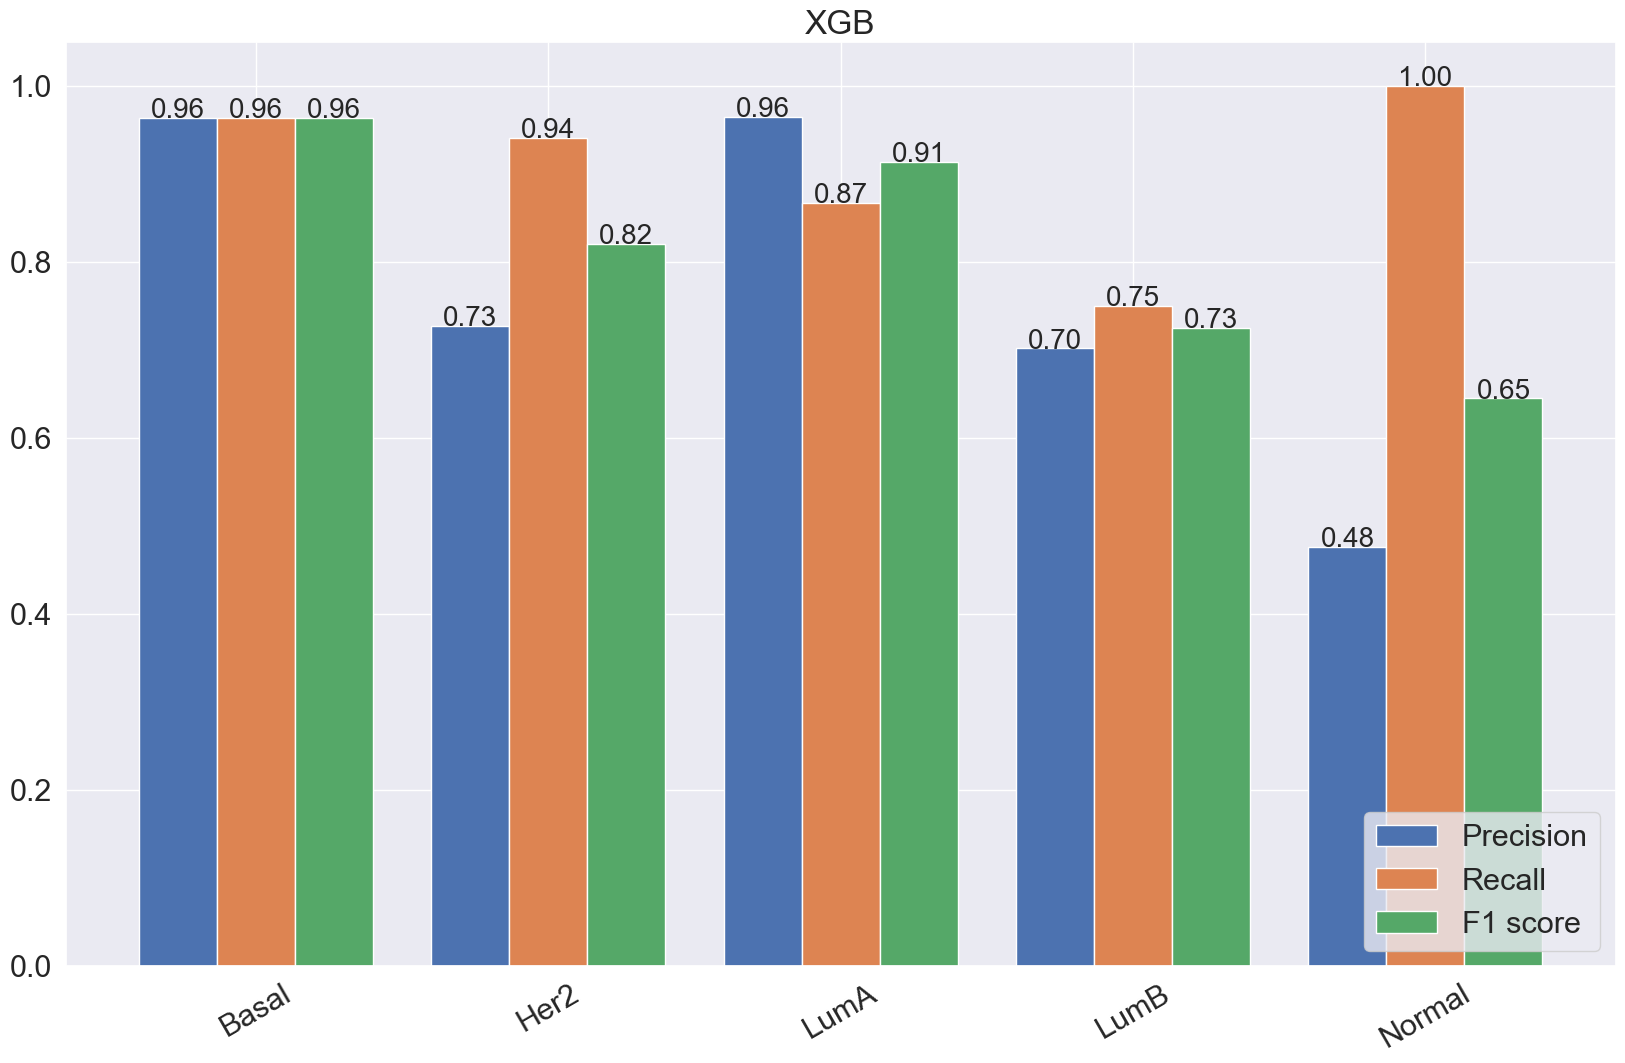

In [ ]:
from utils import cmp_metrics

test_metrics = cmp_metrics(y_test_pam50_orig, xgb_preds)

ax = plt.figure(figsize=(24, 10))
df_lr = pd.DataFrame({'Precision': test_metrics['Precision per class'],
                'Recall': test_metrics['Recall per class'],
                'F1 score': test_metrics['F1 score per class']}, 
                index=xgb_br_preds.columns)
ax = df_lr.plot(kind='bar', rot=30, title='XGB', width=0.8)
# Add values above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=20)
plt.legend(loc='lower right')
plt.gcf().set_size_inches(20, 12)
plt.savefig('../data/brca/predictions/brca_bp_xgb' + '.png')

In [587]:
# Function to set "test" or "train"
def set_test_or_train(id_value):
    if str(id_value) in test_tcga_idx.values:
        return "test"
    else:
        return "train"
    
# Function to get custom sorted indices for each row
def rank_indices(row):
    return row.rank(ascending=False).astype(int)
    
def df_formatting(df: pd.DataFrame, preds: pd.DataFrame, probs: pd.DataFrame) -> pd.DataFrame:
    df_new = df.copy()

    # Take into account the rank of prediction i.e. labels
    ranked_indices = probs.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    ranked_corr_df = pd.DataFrame(ranked_indices.values.tolist(), columns=preds.columns, index=probs.index)
    rank_preds = preds * ranked_corr_df

    # Create the new column using apply()
    df_new['TRAINING OR TESTING'] =  df_new["Patient ID"].apply(set_test_or_train)
    df_new.rename(columns={'expert_PAM50_subtype': 'SUBTYPE'}, inplace=True)
    df_new.rename(columns={'Subtype-from Parker centroids': 'PAM50 SUBTYPE'}, inplace=True)
    df_new['IS LUMA'] = preds['LumA'].astype('bool')
    df_new['IS LUMA PRIMARY'] = rank_preds['LumA'] == 1
    df_new['IS LUMA SECONDARY'] = rank_preds['LumA'] > 1 

    return df_new

def df_add_single_label_formatting(df: pd.DataFrame, preds: pd.DataFrame):
    df_new = df.copy()
    df_new['IS LUMA (single-label)'] = preds == 'LumA'
    return df_new

case = 'deceased' # 'deceased'
if case=='reccured':
    df = df_multi_merged_recc_within_5_years
else:
    df = df_multi_merged

df_xgb_br = df_formatting(df, xgb_br_preds, xgb_br_prob_preds)
df_xgb_cc = df_formatting(df, xgb_cc_preds, xgb_cc_prob_preds)
df_xgb_lp = df_formatting(df, xgb_lp_preds, xgb_lp_prob_preds)
df_lr_br = df_formatting(df, lr_br_preds, lr_br_prob_preds)
df_lr_cc = df_formatting(df, lr_cc_preds, lr_cc_prob_preds)
df_lr_lp = df_formatting(df, lr_lp_preds, lr_lp_prob_preds)
df_svm_lp = df_formatting(df, svm_lp_preds, svm_lp_prob_preds)
# df_rf_lp = df_formatting(df, rf_lp_preds, rf_lp_prob_preds)
# --- Ensemble models ---
df_er_xgb = df_formatting(df, er_xgb_preds, er_xgb_prob_preds)
df_ecc_xgb = df_formatting(df, ecc_xgb_preds, ecc_xgb_prob_preds)
# df_er_lr = df_formatting(df, er_lr_preds, er_lr_prob_preds)
df_ecc_lr = df_formatting(df, ecc_lr_preds, ecc_lr_prob_preds)
df_er_lr = df_formatting(df, er_lr_preds, er_lr_prob_preds)
# df_ecc_svm = df_formatting(df, ecc_svm_preds, ecc_svm_prob_preds)

df_xgb_br = df_add_single_label_formatting(df_xgb_br, xgb_preds)
df_xgb_cc = df_add_single_label_formatting(df_xgb_cc, xgb_preds)
df_xgb_lp = df_add_single_label_formatting(df_xgb_lp, xgb_preds)
df_lr_br = df_add_single_label_formatting(df_lr_br, lr_preds)
df_lr_cc = df_add_single_label_formatting(df_lr_cc, lr_preds)
df_lr_lp = df_add_single_label_formatting(df_lr_lp, lr_preds)
df_svm_lp = df_add_single_label_formatting(df_svm_lp, svm_preds)
# df_rf_lp = df_add_single_label_formatting(df_rf_lp, rf_preds)
# --- Ensemble models ---
df_er_xgb = df_add_single_label_formatting(df_er_xgb, xgb_preds)
df_ecc_xgb = df_add_single_label_formatting(df_ecc_xgb, xgb_preds)
# df_er_lr = df_add_single_label_formatting(df_er_lr, lr_preds)
df_ecc_lr = df_add_single_label_formatting(df_ecc_lr, lr_preds)
df_er_lr = df_add_single_label_formatting(df_er_lr, lr_preds)
# df_ecc_svm = df_add_single_label_formatting(df_ecc_svm, svm_preds)

In [588]:
y_true['PAM50 label'] = y_orig
y_true

,Basal,Her2,LumA,LumB,Normal,PAM50 label
0,0,0,1,0,0,LumA
1,0,1,0,0,0,Her2
2,0,0,0,1,0,LumB
3,0,0,1,0,2,LumA
4,0,0,1,0,2,LumA
...,...,...,...,...,...,...
1048,0,0,2,0,1,Normal
1049,0,0,0,0,1,Normal
1050,0,0,0,0,1,Normal
1051,0,0,2,0,1,Normal


In [589]:
(y_mcut_5perc_labels.sum(axis=1) == 0).sum()

0

In [590]:
y_pam50

0         LumA
1         Her2
2         LumB
3         LumA
4         LumA
         ...  
1048    Normal
1049    Normal
1050    Normal
1051    Normal
1052    Normal
Name: Subtype-from Parker centroids, Length: 1053, dtype: object

In [591]:
y_pam50[30]

'LumA'

In [592]:
y_mcut_5perc_labels.iloc[30, :]

Basal     0
Her2      0
LumA      1
LumB      0
Normal    0
Name: 30, dtype: int64

In [593]:
y_true.iloc[30, :]

Basal             0
Her2              0
LumA              1
LumB              0
Normal            0
PAM50 label    Her2
Name: 30, dtype: object

In [594]:
(y_true.sum(axis=1) == 0).sum()

0

In [595]:
y_true = y_mcut_5perc_labels.copy()
for i, row in y_mcut_5perc_labels.iterrows():
    for col in y_mcut_5perc_labels.columns:
        if row[col] == 1 and col != y_pam50[i]:
            y_true.loc[i, col] = 2
y_true['PAM50 label'] = y_pam50
y_true.to_csv('../data/brca/predictions/ground_truth.csv', index=True)

y_true, y_mcut_5perc_labels

(      Basal  Her2  LumA  LumB  Normal PAM50 label
 0         0     0     1     0       0        LumA
 1         0     1     0     0       0        Her2
 2         0     0     0     1       0        LumB
 3         0     0     1     0       2        LumA
 4         0     0     1     0       2        LumA
 ...     ...   ...   ...   ...     ...         ...
 1048      0     0     2     0       1      Normal
 1049      0     0     0     0       1      Normal
 1050      0     0     0     0       1      Normal
 1051      0     0     2     0       1      Normal
 1052      2     0     0     0       1      Normal
 
 [1053 rows x 6 columns],
       Basal  Her2  LumA  LumB  Normal
 0         0     0     1     0       0
 1         0     1     0     0       0
 2         0     0     0     1       0
 3         0     0     1     0       1
 4         0     0     1     0       1
 ...     ...   ...   ...   ...     ...
 1048      0     0     1     0       1
 1049      0     0     0     0       1
 1050    

In [596]:
# Extract only test samples
df_xgb_br_test = df_xgb_br[df_xgb_br['TRAINING OR TESTING'] == 'test']
df_xgb_cc_test = df_xgb_cc[df_xgb_cc['TRAINING OR TESTING'] == 'test']
df_xgb_lp_test = df_xgb_lp[df_xgb_lp['TRAINING OR TESTING'] == 'test']
df_lr_br_test = df_lr_br[df_lr_br['TRAINING OR TESTING'] == 'test']
df_lr_cc_test = df_lr_cc[df_lr_cc['TRAINING OR TESTING'] == 'test']
df_lr_lp_test = df_lr_lp[df_lr_lp['TRAINING OR TESTING'] == 'test']
df_svm_lp_test = df_svm_lp[df_svm_lp['TRAINING OR TESTING'] == 'test']
# df_rf_lp_test = df_rf_lp[df_rf_lp['TRAINING OR TESTING'] == 'test']
# ---- Ensemble ----
df_er_xgb_test = df_er_xgb[df_er_xgb['TRAINING OR TESTING'] == 'test'] 
df_ecc_xgb_test = df_ecc_xgb[df_ecc_xgb['TRAINING OR TESTING'] == 'test'] 
# df_er_lr_test = df_er_lr[df_er_lr['TRAINING OR TESTING'] == 'test'] 
df_ecc_lr_test = df_ecc_lr[df_ecc_lr['TRAINING OR TESTING'] == 'test'] 
df_er_lr_test = df_er_lr[df_er_lr['TRAINING OR TESTING'] == 'test'] 
# df_ecc_svm_test = df_ecc_svm[df_ecc_svm['TRAINING OR TESTING'] == 'test'] 

# Extract only train samples
df_xgb_br_train = df_xgb_br[df_xgb_br['TRAINING OR TESTING'] == 'train']
df_xgb_cc_train = df_xgb_cc[df_xgb_cc['TRAINING OR TESTING'] == 'train']
df_xgb_lp_train = df_xgb_lp[df_xgb_lp['TRAINING OR TESTING'] == 'train']
df_lr_br_train = df_lr_br[df_lr_br['TRAINING OR TESTING'] == 'train']
df_lr_cc_train = df_lr_cc[df_lr_cc['TRAINING OR TESTING'] == 'train']
df_lr_lp_train = df_lr_lp[df_lr_lp['TRAINING OR TESTING'] == 'train']
df_svm_lp_train = df_svm_lp[df_svm_lp['TRAINING OR TESTING'] == 'train']
# df_rf_lp_train = df_rf_lp[df_rf_lp['TRAINING OR TESTING'] == 'train']
# ---- Ensemble ----
df_er_xgb_train = df_er_xgb[df_er_xgb['TRAINING OR TESTING'] == 'train'] 
df_ecc_xgb_train = df_ecc_xgb[df_ecc_xgb['TRAINING OR TESTING'] == 'train'] 
# df_er_lr_train = df_er_lr[df_er_lr['TRAINING OR TESTING'] == 'train'] 
df_ecc_lr_train = df_ecc_lr[df_ecc_lr['TRAINING OR TESTING'] == 'train'] 
df_er_lr_train = df_er_lr[df_er_lr['TRAINING OR TESTING'] == 'train'] 
# df_ecc_svm_train = df_ecc_svm[df_ecc_svm['TRAINING OR TESTING'] == 'train'] 

In [597]:
# Modify training data since it has NaNs 
# (the labels and ranks need to be extracyed from memberships and m-cut + 5perc labels)

def add_values_to_train_samples(df: pd.DataFrame):

    # Perker subtype is a primary
    df['IS LUMA'] = y_mcut_5perc_labels.loc[df.index].apply(lambda row: 'LumA' in row.values*y_mcut_5perc_labels.columns, axis=1)
    df['IS LUMA PRIMARY'] = df_multi.loc[df.index, 'Subtype-from Parker centroids'] == 'LumA'
    df['IS LUMA (single-label)'] = df_multi.loc[df.index, 'Subtype-from Parker centroids'] == 'LumA'

    # Take into account the rank of prediction i.e. labels
    memberships = df_multi.iloc[df.index, -5:]
    ranked_indices = memberships.apply(rank_indices, axis=1)

    # Create DataFrame from ranked values
    rank_membs = ranked_indices * y_mcut_5perc_labels.loc[df.index]

    df['IS LUMA SECONDARY'] = rank_membs['LumA'] == 2
    return df

df_xgb_br_train = add_values_to_train_samples(df_xgb_br_train)
df_xgb_cc_train = add_values_to_train_samples(df_xgb_cc_train)
df_xgb_lp_train = add_values_to_train_samples(df_xgb_lp_train)
df_lr_br_train = add_values_to_train_samples(df_lr_br_train)
df_lr_cc_train = add_values_to_train_samples(df_lr_cc_train)
df_lr_lp_train = add_values_to_train_samples(df_lr_lp_train)
df_svm_lp_train = add_values_to_train_samples(df_svm_lp_train)
# df_rf_lp_train = add_values_to_train_samples(df_rf_lp_train)
# --- Ensemble ---
df_er_xgb_train = add_values_to_train_samples(df_er_xgb_train)
df_ecc_xgb_train = add_values_to_train_samples(df_ecc_xgb_train)
# df_er_lr_train = add_values_to_train_samples(df_er_lr_train)
df_ecc_lr_train = add_values_to_train_samples(df_ecc_lr_train)
df_er_lr_train = add_values_to_train_samples(df_er_lr_train)
# df_ecc_svm_train = add_values_to_train_samples(df_ecc_svm_train)

In [598]:
df_xgb_br_test

,Patient ID,SUBTYPE,PAM50 SUBTYPE,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,...,DISEASE FREE FOR LESS THAN 10 YEARS,RECURRED AFTER 10 YEARS,RECURRED BEFORE 10 YEARS,DECEASED WITHIN 10 YEARS,Reccured within 5 years,TRAINING OR TESTING,IS LUMA,IS LUMA PRIMARY,IS LUMA SECONDARY,IS LUMA (single-label)
1,TCGA-3C-AALI,Her2,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,...,False,False,False,False,False,test,False,False,False,False
4,TCGA-4H-AAAK,LumA,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,...,True,False,False,False,True,test,True,True,False,True
10,TCGA-A2-A0D1,Her2,Her2,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,...,True,False,False,False,True,test,False,False,False,False
11,TCGA-A2-A0YE,Basal,Basal,DiseaseFree,18.213499,LIVING,18.213499,False,True,False,...,True,False,False,False,True,test,False,False,False,False
13,TCGA-A2-A4S1,Basal,Basal,DiseaseFree,26.958609,LIVING,26.958609,False,True,False,...,True,False,False,False,True,test,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040,TCGA-AC-A2FK,Normal,Normal,DiseaseFree,87.122333,LIVING,87.122333,True,False,False,...,True,False,False,False,False,test,True,False,True,False
1043,TCGA-AR-A2LH,Normal,Normal,Recurred/Progressed,14.268337,DECEASED,20.251833,False,False,False,...,False,False,True,True,True,test,True,False,True,False
1047,TCGA-BH-A28O,Normal,Normal,DiseaseFree,36.821514,LIVING,36.821514,False,True,False,...,True,False,False,False,True,test,True,False,True,False
1050,TCGA-EW-A1P7,Normal,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,...,False,False,True,False,True,test,False,False,False,False


In [599]:
def write_disease_status(df, years=5):
    if years==5:
        disease_status = ['DISEASE FREE FOR MORE THAN {} YEARS'.format(years), 
                        'DISEASE FREE FOR LESS THAN {} YEARS'.format(years),	
                        'RECURRED AFTER {} YEARS'.format(years),	
                        'RECURRED BEFORE {} YEARS'.format(years),	
                        'DECEASED WITHIN {} YEARS'.format(years),
                        'Reccured within {} years'.format(years)
                        ]
    else:
        disease_status = ['DISEASE FREE FOR MORE THAN {} YEARS'.format(years), 
                        'DISEASE FREE FOR LESS THAN {} YEARS'.format(years),	
                        'RECURRED AFTER {} YEARS'.format(years),	
                        'RECURRED BEFORE {} YEARS'.format(years),	
                        'DECEASED WITHIN {} YEARS'.format(years),
                        ]

    return df[disease_status].sum(axis=0)

print(write_disease_status(df_xgb_cc, years=5), '\n')
print(write_disease_status(df_xgb_cc_test, years=5), '\n')

DISEASE FREE FOR MORE THAN 5 YEARS    177
DISEASE FREE FOR LESS THAN 5 YEARS    654
RECURRED AFTER 5 YEARS                 10
RECURRED BEFORE 5 YEARS                71
DECEASED WITHIN 5 YEARS                55
Reccured within 5 years               735
dtype: object 

DISEASE FREE FOR MORE THAN 5 YEARS     51
DISEASE FREE FOR LESS THAN 5 YEARS    196
RECURRED AFTER 5 YEARS                  3
RECURRED BEFORE 5 YEARS                20
DECEASED WITHIN 5 YEARS                19
Reccured within 5 years               219
dtype: object 



In [600]:
print(write_disease_status(df_xgb_cc, years=10), '\n')
print(write_disease_status(df_xgb_cc_test, years=10), '\n')

DISEASE FREE FOR MORE THAN 10 YEARS     27
DISEASE FREE FOR LESS THAN 10 YEARS    804
RECURRED AFTER 10 YEARS                  1
RECURRED BEFORE 10 YEARS                80
DECEASED WITHIN 10 YEARS                77
dtype: object 

DISEASE FREE FOR MORE THAN 10 YEARS     11
DISEASE FREE FOR LESS THAN 10 YEARS    236
RECURRED AFTER 10 YEARS                  0
RECURRED BEFORE 10 YEARS                23
DECEASED WITHIN 10 YEARS                26
dtype: object 



# Kaplan Meier survival curves

The survival analysis measures the time to an event which in our case can be:
* dicease free for more and for less than 5 years
* recurred after and before 5 years
* diceased within 5 years

Before obtaining KM curves, two groups need to be made, and these are the scenarios we are going to analyze:
* LumA (no matter the rank) vs. not LumA
* LumA primary vs. not LumA
* LumA secondary vs. not LumA


In [601]:
df_xgb_br

,Patient ID,SUBTYPE,PAM50 SUBTYPE,DFS_STATUS,DFS_MONTHS,OS_STATUS,OS_MONTHS,DISEASE FREE FOR MORE THAN 5 YEARS,DISEASE FREE FOR LESS THAN 5 YEARS,RECURRED AFTER 5 YEARS,...,DISEASE FREE FOR LESS THAN 10 YEARS,RECURRED AFTER 10 YEARS,RECURRED BEFORE 10 YEARS,DECEASED WITHIN 10 YEARS,Reccured within 5 years,TRAINING OR TESTING,IS LUMA,IS LUMA PRIMARY,IS LUMA SECONDARY,IS LUMA (single-label)
0,TCGA-3C-AAAU,LumA,LumA,Recurred/Progressed,59.440444,LIVING,133.050597,False,False,False,...,False,False,True,False,True,train,True,True,False,True
1,TCGA-3C-AALI,Her2,Her2,DiseaseFree,131.669790,LIVING,131.669790,True,False,False,...,False,False,False,False,False,test,False,False,False,False
2,TCGA-3C-AALJ,LumB,LumB,DiseaseFree,48.459743,LIVING,48.459743,False,True,False,...,True,False,False,False,True,train,False,False,False,False
4,TCGA-4H-AAAK,LumA,LumA,DiseaseFree,11.440971,LIVING,11.440971,False,True,False,...,True,False,False,False,True,test,True,True,False,True
7,TCGA-A1-A0SG,LumA,LumA,DiseaseFree,14.268337,LIVING,14.268337,False,True,False,...,True,False,False,False,True,train,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048,TCGA-BH-A42U,Normal,Normal,DiseaseFree,110.596048,LIVING,110.596048,True,False,False,...,True,False,False,False,False,train,True,False,True,False
1049,TCGA-E2-A108,Normal,Normal,DiseaseFree,27.517507,LIVING,27.517507,False,True,False,...,True,False,False,False,True,train,False,False,False,False
1050,TCGA-EW-A1P7,Normal,Normal,Recurred/Progressed,23.966861,LIVING,30.081862,False,False,False,...,False,False,True,False,True,test,False,False,False,False
1051,TCGA-EW-A1PG,Normal,Normal,DiseaseFree,34.553046,LIVING,34.553046,False,True,False,...,True,False,False,False,True,test,True,False,True,False


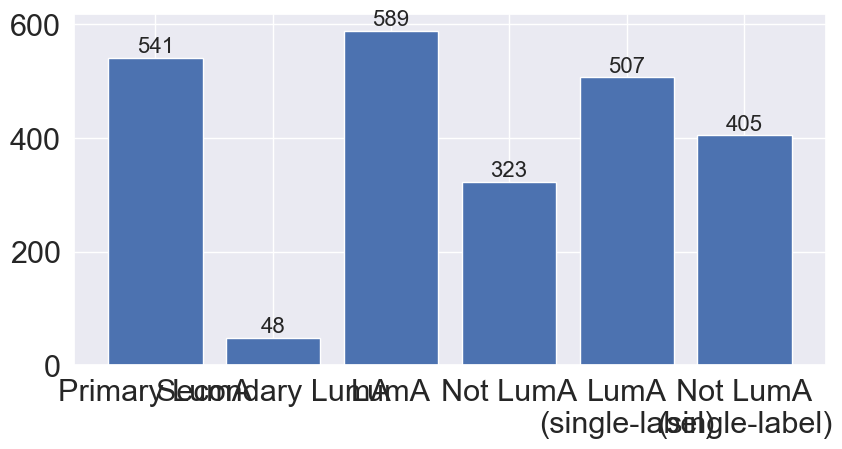

In [608]:
# Create groups
def create_groups(df: pd.DataFrame):
    group_not_LumA = df[df['IS LUMA'] == False]
    group_LumA = df[df['IS LUMA'] == True]
    group_LumA_primary = df[df['IS LUMA PRIMARY'] == True]
    group_LumA_secondary = df[df['IS LUMA SECONDARY'] == True]
    group_not_LumA_single = df[df['IS LUMA (single-label)'] == False]
    group_LumA_single = df[df['IS LUMA (single-label)'] == True]


    counts = [group_LumA_primary.shape[0], group_LumA_secondary.shape[0], 
              group_LumA.shape[0], group_not_LumA.shape[0], 
            group_LumA_single.shape[0], group_not_LumA_single.shape[0]]
    labels = ['Primary LumA', 'Secondary LumA', 'LumA', 'Not LumA', 'LumA\n(single-label)', 'Not LumA\n(single-label)']

    # Create a bar plot
    plt.figure(figsize=(9,5))
    plt.bar(range(len(counts)), counts, tick_label=labels)

    # Add exact numbers as annotations above the bars
    for i, v in enumerate(counts):
        plt.text(i, v + 2, str(v), ha='center', va='bottom', fontsize=16)
    plt.tight_layout()

    return group_not_LumA, group_LumA, group_LumA_primary, group_LumA_secondary, group_not_LumA_single, group_LumA_single

group_not_LumA, group_LumA, group_LumA_primary, group_LumA_secondary, group_not_LumA_single, group_LumA_single = create_groups(df_er_xgb)

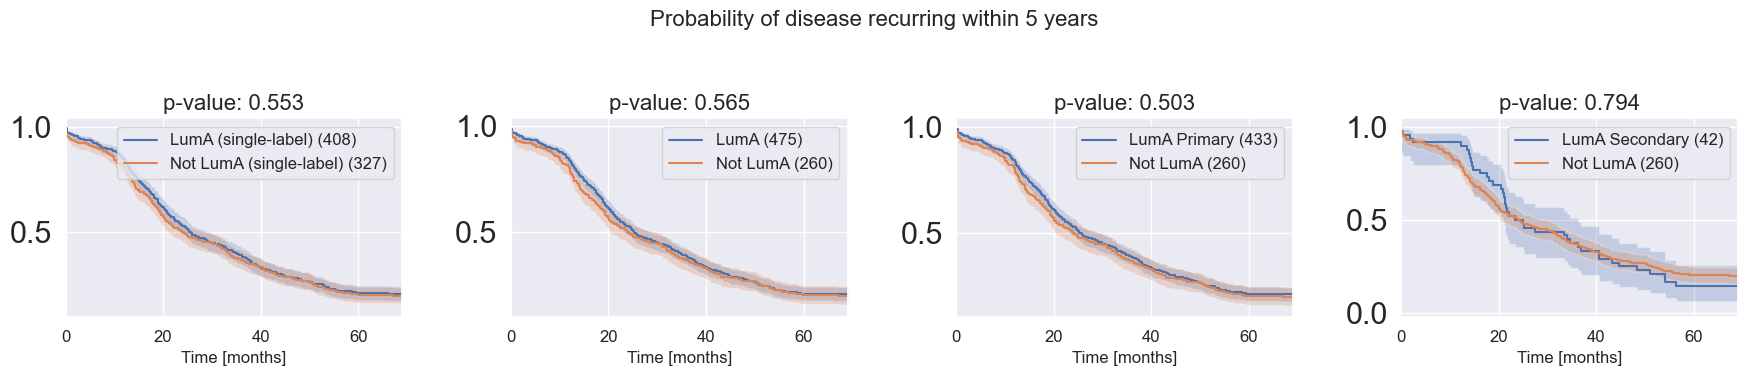

In [609]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from lifelines.statistics import logrank_test
from matplotlib.offsetbox import AnchoredText

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4)) # 10, 8
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumA Secondary']
mask = 'Reccured within 5 years' # DISEASE FREE FOR MORE THAN 5 YEARS

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    # Compute cardinality of health status vs group
    positive_counts = (df_group[mask]).sum()
    negative_count = group_not_LumA[mask].sum()
    
    e1, t1 = df_group[mask].astype('bool'), df_group['DFS_MONTHS']
    e2, t2 = group_not_LumA[mask].astype('bool'), group_not_LumA['DFS_MONTHS']

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=e1,
        time_exit=t1, 
        conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=e2,
        time_exit=t2, 
        conf_type='log-log'
    )
    p_value = logrank_test(t1, t2, e1, e2).p_value

    axes[i+1].step(time, survival_prob, where='post', label=group_names[i] + ' ({})'.format(positive_counts))
    axes[i+1].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i+1].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA ({})'.format(negative_count))
    axes[i+1].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i+1].set_xlabel('Time [months]', fontsize=12)
    axes[i+1].legend(loc='best', fontsize=12)
    axes[i+1].xaxis.set_tick_params(labelsize=12)
    axes[i+1].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
    axes[i+1].set_xlim([0, 69]) # [51, max(time_not_LumA[-1], time[-1])]

    # anchored_text = AnchoredText("p-value: {:0.3}".format(p_value), loc=1, frameon=False)
    # axes[i].add_artist(anchored_text)

# Compute cardinality of health status vs group
positive_counts = (group_LumA_single[mask]).sum()
negative_count = group_not_LumA_single[mask].sum()

e1, t1 = group_LumA_single[mask].astype('bool'), group_LumA_single['DFS_MONTHS']
e2, t2 = group_not_LumA_single[mask].astype('bool'), group_not_LumA_single['DFS_MONTHS']

time, survival_prob, conf_int = kaplan_meier_estimator(
    event=e1,
    time_exit=t1, 
    conf_type='log-log'
)

time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
    event=e2,
    time_exit=t2, 
    conf_type='log-log'
)
p_value = logrank_test(t1, t2, e1, e2).p_value

axes[0].step(time, survival_prob, where='post', label='LumA (single-label) ({})'.format(positive_counts))
axes[0].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
axes[0].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA (single-label) ({})'.format(negative_count))
axes[0].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

axes[0].set_xlabel('Time [months]', fontsize=12)
axes[0].legend(fontsize=12)
axes[0].xaxis.set_tick_params(labelsize=12)
axes[0].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
axes[0].set_xlim([0, 69]) # max(time_not_LumA[-1], time[-1]

fig.suptitle('Probability of disease recurring within 5 years', fontsize=16)

plt.tight_layout()

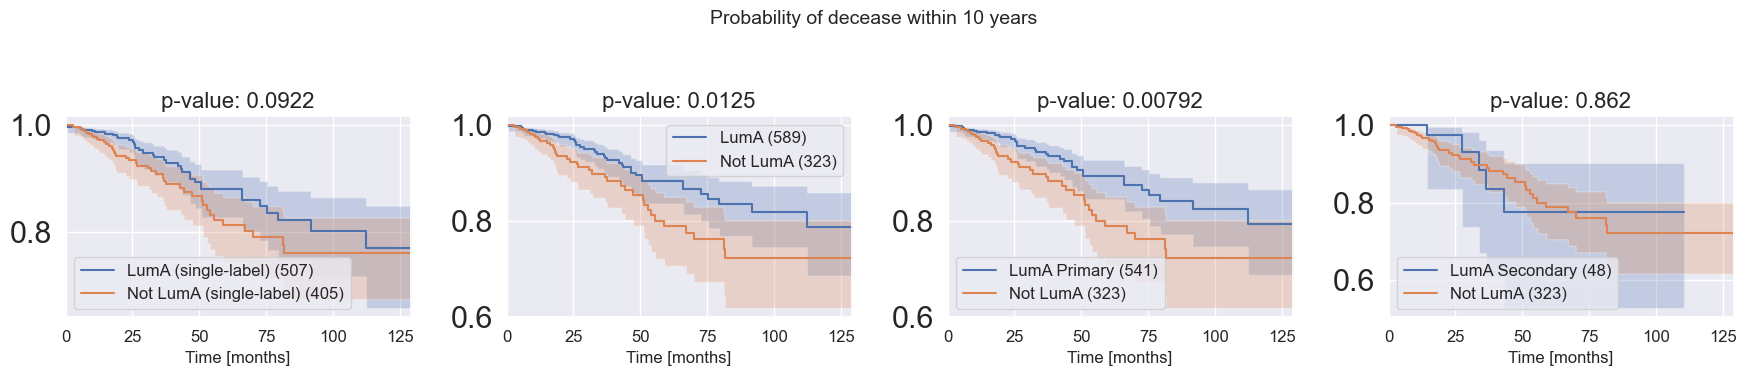

In [610]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))
axes = axes.flatten()
group_names = ['LumA', 'LumA Primary', 'LumA Secondary']
mask = 'DECEASED WITHIN 10 YEARS' # DECEASED WITHIN 5 YEARS

for i, df_group in enumerate([group_LumA, group_LumA_primary, group_LumA_secondary]):

    # Compute cardinality of health status vs group
    positive_counts = (df_group[mask]).sum()
    negative_count = group_not_LumA[mask].sum()

    e1, t1 = df_group[mask].astype('bool'), df_group['DFS_MONTHS']
    e2, t2 = group_not_LumA[mask].astype('bool'), group_not_LumA['DFS_MONTHS']

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=e1,
        time_exit=t1, 
        conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=e2,
        time_exit=t2, 
        conf_type='log-log'
    )
    p_value = logrank_test(t1, t2, e1, e2).p_value

    axes[i+1].step(time, survival_prob, where='post', label=group_names[i] + ' ({})'.format(e1.shape[0]))
    axes[i+1].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i+1].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA ({})'.format(e2.shape[0]))
    axes[i+1].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i+1].set_xlabel('Time [months]', fontsize=12)
    axes[i+1].legend(loc='best', fontsize=12)
    axes[i+1].xaxis.set_tick_params(labelsize=12)
    axes[i+1].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
    axes[i+1].set_xlim([0, 129]) # 69

# Compute cardinality of health status vs group
positive_counts = (group_LumA_single[mask]).sum()
negative_count = group_not_LumA_single[mask].sum()

e1, t1 = group_LumA_single[mask].astype('bool'), group_LumA_single['DFS_MONTHS']
e2, t2 = group_not_LumA_single[mask].astype('bool'), group_not_LumA_single['DFS_MONTHS']

time, survival_prob, conf_int = kaplan_meier_estimator(
    event=e1,
    time_exit=t1, 
    conf_type='log-log'
)

time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
    event=e2,
    time_exit=t2, 
    conf_type='log-log'
)
p_value = logrank_test(t1, t2, e1, e2).p_value

axes[0].step(time, survival_prob, where='post', label='LumA (single-label) ({})'.format(e1.shape[0]))
axes[0].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
axes[0].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA (single-label) ({})'.format(e2.shape[0]))
axes[0].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

axes[0].set_xlabel('Time [months]', fontsize=12)
axes[0].legend(fontsize=12)
axes[0].xaxis.set_tick_params(labelsize=12)
axes[0].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
axes[0].set_xlim([0, 129])

fig.suptitle('Probability of decease within 10 years', fontsize=14)
plt.tight_layout()

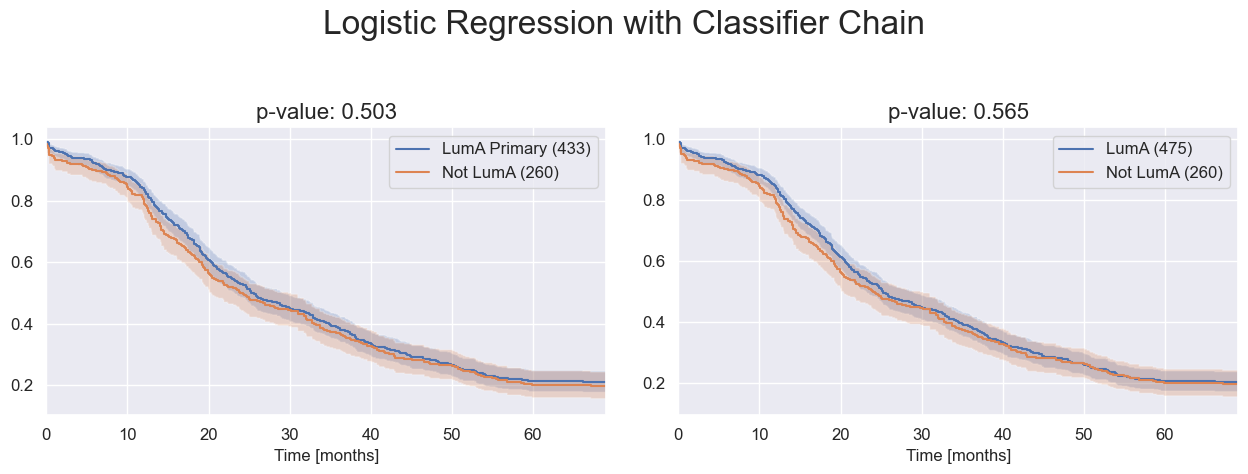

In [611]:
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.compare import compare_survival
from lifelines.statistics import logrank_test
from matplotlib.offsetbox import AnchoredText

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5)) # 10, 8
axes = axes.flatten()
group_names = ['LumA Primary', 'LumA']
mask = 'Reccured within 5 years' # DISEASE FREE FOR MORE THAN 5 YEARS

for i, df_group in enumerate([group_LumA_primary, group_LumA]):

    # Compute cardinality of health status vs group
    positive_counts = (df_group[mask]).sum()
    negative_count = group_not_LumA[mask].sum()
    
    e1, t1 = df_group[mask].astype('bool'), df_group['DFS_MONTHS']
    e2, t2 = group_not_LumA[mask].astype('bool'), group_not_LumA['DFS_MONTHS']

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=e1,
        time_exit=t1, 
        conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=e2,
        time_exit=t2, 
        conf_type='log-log'
    )
    p_value = logrank_test(t1, t2, e1, e2).p_value

    axes[i].step(time, survival_prob, where='post', label=group_names[i] + ' ({})'.format(positive_counts))
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA ({})'.format(negative_count))
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [months]', fontsize=12)
    axes[i].legend(loc='best', fontsize=12)
    axes[i].xaxis.set_tick_params(labelsize=12)
    axes[i].yaxis.set_tick_params(labelsize=12)
    axes[i].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
    axes[i].set_xlim([0, 69]) # [51, max(time_not_LumA[-1], time[-1])]

    # anchored_text = AnchoredText("p-value: {:0.3}".format(p_value), loc=1, frameon=False)
    # axes[i].add_artist(anchored_text)

# Compute cardinality of health status vs group
positive_counts = (group_LumA_single[mask]).sum()
negative_count = group_not_LumA_single[mask].sum()

e1, t1 = group_LumA_single[mask].astype('bool'), group_LumA_single['DFS_MONTHS']
e2, t2 = group_not_LumA_single[mask].astype('bool'), group_not_LumA_single['DFS_MONTHS']

time, survival_prob, conf_int = kaplan_meier_estimator(
    event=e1,
    time_exit=t1, 
    conf_type='log-log'
)

time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
    event=e2,
    time_exit=t2, 
    conf_type='log-log'
)
p_value = logrank_test(t1, t2, e1, e2).p_value

fig.suptitle('Logistic Regression with Classifier Chain', fontsize=24)

plt.tight_layout()

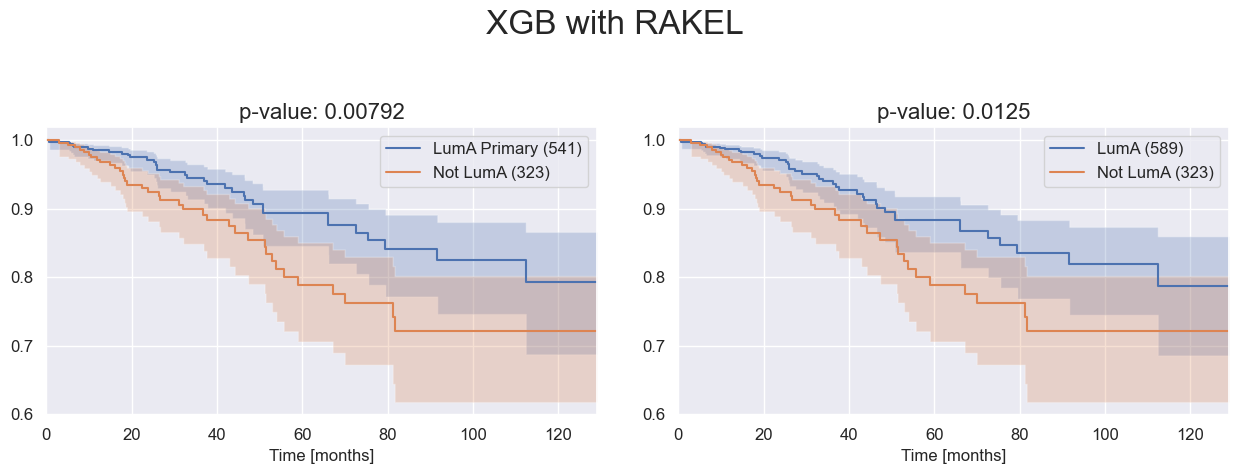

In [613]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
axes = axes.flatten()
group_names = ['LumA Primary', 'LumA']
mask = 'DECEASED WITHIN 10 YEARS' # DECEASED WITHIN 5 YEARS

for i, df_group in enumerate([group_LumA_primary, group_LumA]):

    # Compute cardinality of health status vs group
    positive_counts = (df_group[mask]).sum()
    negative_count = group_not_LumA[mask].sum()

    e1, t1 = df_group[mask].astype('bool'), df_group['DFS_MONTHS']
    e2, t2 = group_not_LumA[mask].astype('bool'), group_not_LumA['DFS_MONTHS']

    time, survival_prob, conf_int = kaplan_meier_estimator(
        event=e1,
        time_exit=t1, 
        conf_type='log-log'
    )

    time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
        event=e2,
        time_exit=t2, 
        conf_type='log-log'
    )
    p_value = logrank_test(t1, t2, e1, e2).p_value

    axes[i].step(time, survival_prob, where='post', label=group_names[i] + ' ({})'.format(e1.shape[0]))
    axes[i].fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
    axes[i].step(time_not_LumA, survival_prob_not_LumA, where='post', label='Not LumA ({})'.format(e2.shape[0]))
    axes[i].fill_between(time_not_LumA, conf_int_not_LumA[0], conf_int_not_LumA[1], alpha=0.25, step="post")

    axes[i].set_xlabel('Time [months]', fontsize=12)
    axes[i].legend(loc='best', fontsize=12)
    axes[i].xaxis.set_tick_params(labelsize=12)
    axes[i].yaxis.set_tick_params(labelsize=12)
    axes[i].set_title("p-value: {:0.3}".format(p_value), fontsize=16)
    axes[i].set_xlim([0, 129]) # 69

# Compute cardinality of health status vs group
positive_counts = (group_LumA_single[mask]).sum()
negative_count = group_not_LumA_single[mask].sum()

e1, t1 = group_LumA_single[mask].astype('bool'), group_LumA_single['DFS_MONTHS']
e2, t2 = group_not_LumA_single[mask].astype('bool'), group_not_LumA_single['DFS_MONTHS']

time, survival_prob, conf_int = kaplan_meier_estimator(
    event=e1,
    time_exit=t1, 
    conf_type='log-log'
)

time_not_LumA, survival_prob_not_LumA, conf_int_not_LumA = kaplan_meier_estimator(
    event=e2,
    time_exit=t2, 
    conf_type='log-log'
)
p_value = logrank_test(t1, t2, e1, e2).p_value

fig.suptitle('XGB with RAKEL', fontsize=24)
plt.tight_layout()